Sources:</br>

[airflow.apache.org](https://airflow.apache.org/docs/apache-airflow/stable/core-concepts/dags.html) </br>

[code2j Youtube channel](https://www.youtube.com/@coder2j)</br>

[Data Pipelines with Apache Airflow book](https://livebook.manning.com/book/data-pipelines-with-apache-airflow/welcome/v-6/7)</br>

[ETL and Data Pipelines with Shell, Airflow and Kafka course](https://www.coursera.org/learn/etl-and-data-pipelines-shell-airflow-kafka)</br>
<hr>

<a id="airflow-basic-concepts"></a>
## Airflow basic concepts
<a id="what-is-airflow"></a>
### What airflow is?
Airflow starts as Airbnb internal tool to manage complex workflows in 2014.</br>
Airflow is one of the most popular workflow management platforms.</br>
It is written in python.</br>

### What is workflow?
Workflow is the sequence of tasks.</br>
In Airflow, workflow defined as __DAGs__ (Directed Acyclic Graph).</br>
For instance, we have a workflow which starts with A, when A finishes it followed by task B and D; and when B and D finished it followed by their sequences.</br>
note: We can't have cycles in a workflow! If task B finishes, it's not allowed to run task A again.</br>

### Task
It defines as a unit of work within a DAG.
It represented as a node in a DAG graph.
There is a dependency between each pair of consecutive Tasks, for example Task B is the downstream of Task A which means Task B should start running after Task A; So Task A is the upstream of Task B.

### Operator
Operator determine what actually gets done by a task.</br>
Each Task is an implementation of an Operator.

### Difference between Task and Operator
- Tasks:</br>
They act as managers to ensure that operators execute their Tasks correctly.

- Operators: </br>
Have a single responsibility. </br>
Some of them perform generic work such as BashOperator (used to run a Bash script) or the PythonOperator (used to
run a Python function)</br>
Or some of them have more specific use cases, such as the EmailOperator
(used to send an email) or the SimpleHTTPOperator (used to call an HTTP endpoint)


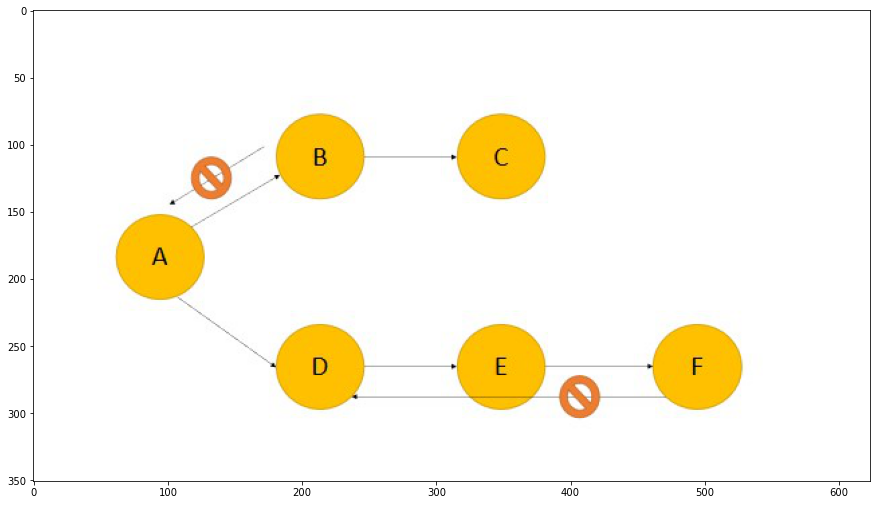

In [8]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
image = mpimg.imread("./Photos/airflow_exp.jpg")
plt.imshow(image)
plt.show()

### Execution Date
Execution Date is the date which the DAG run in.


### You can define DAG like this
- dag_id: Should be unique in the whole airflow deployment
- start_date: Starting time for running DAG, you can also start running DAGs from past dates
- schedule: Defines when DAG should be run, if you set it None you should run your DAG manually</br>

| Schedule | Description | Cron Format |
| -------- | ----------- | ----------- |
| None     | Don’t schedule, use for exclusively “externally triggered” DAGs | N/A |
| @once    | Schedule once and only once | N/A |
| @continuous | Run as soon as the previous run finishes | N/A |
| @hourly  | Run once an hour at the end of the hour | `0 * * * *` |
| @daily   | Run once a day at midnight (24:00) | `0 0 * * *` |
| @weekly  | Run once a week at midnight (24:00) on Sunday | `0 0 * * 0` |
| @monthly | Run once a month at midnight (24:00) of the first day of the month | `0 0 1 * *` |
| @quarterly | Run once a quarter at midnight (24:00) on the first day | `0 0 1 */3 *` |
| @yearly  | Run once a year at midnight (24:00) of January 1 | `0 0 1 1 *` |

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG

default_args = {
    'owner': 'sara',
    'retries': 5, # maximum time of retries
    'retry_delay': timedelta(minutes=2)
}

dag = DAG(
    dag_id="dag_name",
    default_args=default_args,
    start_date=datetime(2023, 6, 20, 8), # 2023/06/20 at 08:00
    schedule="@daily"
)

Now we should add tasks to our DAG</br>
Every task defined by an operator</br>
Every operator should have a unique task_id within a DAG</br>
Each task should have dependencies</br>
- Task has dependency on other tasks, other tasks will be executed before it -> upstream
- Other tasks are dependent on it, a set of tasks will be executed after it -> downstream

In [ ]:
from airflow.operators.bash import BashOperator

task_a = BashOperator(task_id="task_a", dag=dag, bash_command="echo hello world!")
task_b = BashOperator(task_id="task_b", dag=dag, bash_command="second task")
task_c = BashOperator(task_id="task_c", dag=dag, bash_command="third task")

we can show dependencies using "<up stream> >> <down stram> or <down stream> << <up stram>"</br>

In [ ]:
task_a >> task_b
task_a >> task_c

Or

In [ ]:
task_a >> [task_b, task_c]  # b and c are downstream of a | a is upstream of b and c

Or you can use set_downstream or set_upstream as follows:</br>

In [ ]:
task_a.set_downstream(task_b)
task_a.set_downstream(task_c)

<hr>

### Python Operator [more information](https://airflow.apache.org/docs/apache-airflow/stable/howto/operator/python.html)</br>
You can define it like this:

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator

default_args = {
    'owner': 'sara',
    'retries': 5,
    'retry_delay': timedelta(minutes=2)
}

def print_hello_world():
    print("hello world")

def greet(name):
    print(f"Hi! I'm {name}")

dag = DAG(
    dag_id="dag_with_python_operator",
    default_args=default_args,
    start_date=datetime(2023, 6, 20, 8), # 2023/06/20 at 08:00
    schedule="@daily"
)
task_a = PythonOperator(task_id="task_a", dag=dag, python_callable=print_hello_world) # define a python operator
task_b = PythonOperator(task_id="task_b", dag=dag, python_callable=greet, op_kwargs={'name': "Sara"}) # define a python operator with arguments

task_a >> task_b

### How to share data between different tasks?

#### op_kwargs
We can pass python function's parameters using PythonOperator by op_kwargs.
op_kwargs is a dictionary of keyword arguments that will be unpacked in the python function.

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator

default_args = {
    'owner': 'sara',
    'retries': 5,
    'retry_delay': timedelta(minutes=2)
}



def greet(first_name, last_name):
    print(f"Hi! I'm {first_name} {last_name}")


dag = DAG(
    dag_id="dag_with_python_operator",
    default_args=default_args,
    start_date=datetime(2023, 6, 20, 8), # 2023/06/20 at 08:00
    schedule="@daily"
)
task_a = PythonOperator(task_id="task_a", dag=dag, python_callable=greet, op_kwargs={'first_name': 'Sara', 'last_name': 'Rhn'}) # define a python operator with arguments

task_a >> task_b

#### X_Coms

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator

default_args = {
    'owner': 'sara',
    'retries': 5,
    'retry_delay': timedelta(minutes=2)
}


def get_name():
    return "Sara"

def greet(ti):
    name = ti.xcom_pull(task_ids='task_a')
    print(f"Hi! I'm {name}")


dag = DAG(
    dag_id="dag_with_python_operator",
    default_args=default_args,
    start_date=datetime(2023, 6, 20, 8), # 2023/06/20 at 08:00
    schedule="@daily"
)
task_a = PythonOperator(task_id="task_a", dag=dag, python_callable=get_name) # define a python operator
task_b = PythonOperator(task_id="task_b", dag=dag, python_callable=greet) # define a python operator with arguments

task_a >> task_b

##### How to push multiple values to XComs in the same function?

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator

default_args = {
    'owner': 'sara',
    'retries': 5,
    'retry_delay': timedelta(minutes=2)
}


def get_name(ti):
    ti.xcom_push(key='first_name', value='Sara')
    ti.xcom_push(key='last_name', value='Rhn')

def greet(ti):
    first_name = context['ti'].xcom_pull(task_ids='task_a', key='first_name')
    last_name = context['ti'].xcom_pull(task_ids='task_a', key='last_name')
    print(f"Hi! I'm {first_name} {last_name}")


dag = DAG(
    dag_id="dag_with_python_operator",
    default_args=default_args,
    start_date=datetime(2023, 6, 20, 8), # 2023/06/20 at 08:00
    schedule="@daily"
)
task_a = PythonOperator(task_id="task_a", dag=dag, python_callable=get_name) # define a python operator
task_b = PythonOperator(task_id="task_b", dag=dag, python_callable=greet) # define a python operator with arguments

task_a >> task_b

<hr>

### How to perform SELECT queries or INSERT data into SQL Server?
##### How to create a connection?
You can do it with the UI. [more information](https://airflow.apache.org/docs/apache-airflow/stable/howto/connection.html#creating-a-connection-with-the-ui)</br>
Then on the top of your codes define your conn_id and use it in your tasks.
#### 1) MsSqlHook [more information](https://airflow.apache.org/docs/apache-airflow-providers-microsoft-mssql/1.0.0/_api/airflow/providers/microsoft/mssql/hooks/mssql/index.html)

In [ ]:
conn_id = <connection_id>
from airflow.providers.microsoft.mssql.hooks.mssql import MsSqlHook
def insert_surveys_to_sql_server():
    hook = MsSqlHook(mssql_conn_id=conn_id)
    sql = (f"""SELECT * FROM <table_name>;""")
    hook.run(sql)

<a id="sql-server-operator"></a>
#### 2) SQL Server Operator [more information](https://airflow.apache.org/docs/apache-airflow-providers-microsoft-mssql/stable/operators.html)

In [ ]:
op = MsSqlOperator(
    task_id="task_b",
    mssql_conn_id="airflow_mssql",
    sql=f"""
        SELECT * FROM <table_name>;
    """,
    dag=dag,
)